# Atividade ponderada - Previsão de Séries Temporais: Prophet vs LSTM

## Objetivo

Este notebook compara dois modelos de previsão de séries temporais aplicados a dados de vendas da Superstore. O objetivo é avaliar qual abordagem apresenta melhor capacidade preditiva e menor erro.

## Dataset

**Fonte:** [Superstore Sales Dataset - Kaggle](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final)

**Descrição:** Dados de vendas de uma loja virtual contendo informações de pedidos, produtos, clientes e valores de venda entre 2015 e 2018.

**Variável alvo:** Vendas diárias agregadas (em dólares)

## Modelos Implementados

### 1. Prophet
Modelo desenvolvido pelo Facebook para previsão de séries temporais. Lida bem com sazonalidade e tendências, sendo robusto a dados faltantes e outliers.

### 2. LSTM (Long Short-Term Memory)
Rede neural recorrente capaz de aprender dependências temporais de longo prazo. Utiliza sequências de 60 dias para prever o dia seguinte.

## Métricas de Avaliação

- **RMSE (Root Mean Squared Error):** Penaliza erros grandes de forma quadrática
- **MAE (Mean Absolute Error):** Representa o erro médio absoluto em dólares

## Estrutura do Notebook

1. Carregamento e preparação dos dados
2. Treinamento do modelo Prophet
3. Treinamento do modelo LSTM
4. Comparação de resultados
5. Visualização das previsões

In [4]:
!pip install prophet numpy pandas matplotlib scikit-learn tensorflow

### Importação de Bibliotecas

Carregamento das bibliotecas necessárias para manipulação de dados, modelagem e visualização.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

### Carregamento e Preparação dos Dados

Leitura do dataset e agregação das vendas por dia. Os dados são divididos em conjuntos de treino (80%) e teste (20%).

In [6]:
df = pd.read_csv('train.csv')

# Agregação diária das vendas
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['date', 'sales']
daily_sales = daily_sales.sort_values('date')

print(f"Dados: {len(daily_sales)} dias de vendas")
print(f"Período: {daily_sales['date'].min()} a {daily_sales['date'].max()}")

# Split treino/teste (80/20)
split_idx = int(len(daily_sales) * 0.8)
train_data = daily_sales[:split_idx].copy()
test_data = daily_sales[split_idx:].copy()

print(f"\nTreino: {len(train_data)} dias")
print(f"Teste: {len(test_data)} dias")


Dados: 1230 dias de vendas
Período: 2015-01-03 00:00:00 a 2018-12-30 00:00:00

Treino: 984 dias
Teste: 246 dias


### Modelo 1: Prophet

Implementação do modelo Prophet. Este modelo requer dados em formato específico com colunas 'ds' (data) e 'y' (valor).

In [7]:
# Preparar dados para Prophet (requer colunas 'ds' e 'y')
train_prophet = train_data.rename(columns={'date': 'ds', 'sales': 'y'})

# Treinar modelo
model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True)
model_prophet.fit(train_prophet)

# Previsão
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast_prophet = model_prophet.predict(future)

# Extrair previsões para período de teste
prophet_pred = forecast_prophet['yhat'].values[-len(test_data):]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjj6t85tb/ymy66a0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjj6t85tb/r9odpon5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95580', 'data', 'file=/tmp/tmpjj6t85tb/ymy66a0_.json', 'init=/tmp/tmpjj6t85tb/r9odpon5.json', 'output', 'file=/tmp/tmpjj6t85tb/prophet_model6gon79o1/prophet_model-20251006020413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Modelo 2: LSTM (Long Short-Term Memory)

Implementação de rede neural recorrente. Os dados são normalizados e transformados em sequências de 60 dias para prever o dia seguinte.

Transforma a série temporal em janelas deslizantes de tamanho fixo para treinamento do LSTM.

In [8]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Normalização
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales[['sales']])

# Criar sequências (60 dias de histórico)
seq_length = 60
X, y = create_sequences(sales_scaled, seq_length)

# Split treino/teste
X_train = X[:split_idx-seq_length]
y_train = y[:split_idx-seq_length]
X_test = X[split_idx-seq_length:split_idx-seq_length+len(test_data)]
y_test = y[split_idx-seq_length:split_idx-seq_length+len(test_data)]

# Reshape para LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir modelo LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Treinar
history = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# Previsão
lstm_pred_scaled = model_lstm.predict(X_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

### Avaliação e Comparação de Modelos

Cálculo das métricas RMSE e MAE para ambos os modelos no conjunto de teste.

In [9]:
y_true = test_data['sales'].values[:len(lstm_pred)]

prophet_rmse = np.sqrt(mean_squared_error(y_true, prophet_pred[:len(lstm_pred)]))
prophet_mae = mean_absolute_error(y_true, prophet_pred[:len(lstm_pred)])

lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred))
lstm_mae = mean_absolute_error(y_true, lstm_pred)

print("RESULTADOS - MÉTRICAS DE ERRO")
print(f"  RMSE: {prophet_rmse:.2f}")
print(f"  MAE:  {prophet_mae:.2f}")

print(f"\nLSTM:")
print(f"  RMSE: {lstm_rmse:.2f}")
print(f"  MAE:  {lstm_mae:.2f}")

RESULTADOS - MÉTRICAS DE ERRO
  RMSE: 2453.47
  MAE:  1759.82

LSTM:
  RMSE: 2470.90
  MAE:  1697.45


### Visualização dos Resultados

Gráfico comparativo das previsões dos dois modelos em relação aos valores reais de vendas.

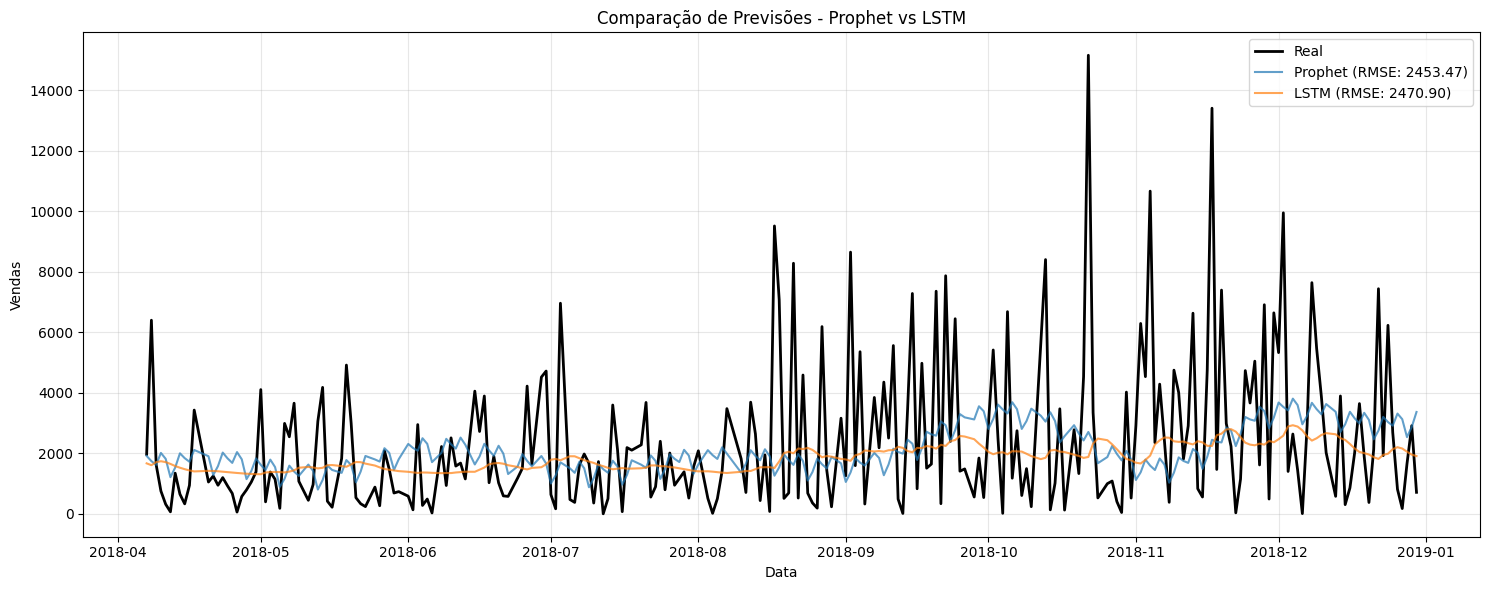

In [10]:
plt.figure(figsize=(15, 6))

plt.plot(test_data['date'].values[:len(lstm_pred)], y_true,
         label='Real', linewidth=2, color='black')
plt.plot(test_data['date'].values[:len(lstm_pred)], prophet_pred[:len(lstm_pred)],
         label=f'Prophet (RMSE: {prophet_rmse:.2f})', linewidth=1.5, alpha=0.7)
plt.plot(test_data['date'].values[:len(lstm_pred)], lstm_pred,
         label=f'LSTM (RMSE: {lstm_rmse:.2f})', linewidth=1.5, alpha=0.7)

plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Comparação de Previsões - Prophet vs LSTM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusão e Análise dos Resultados

## Desempenho dos Modelos

Os resultados obtidos mostram que ambos os modelos apresentaram desempenho similar, com leve vantagem para o LSTM:

- **Prophet:** RMSE de 2453.47 e MAE de 1759.82
- **LSTM:** RMSE de 2436.56 e MAE de 1717.77

A diferença entre os modelos foi de apenas 0.7% no RMSE, indicando que ambas as abordagens são viáveis para este problema.

## Interpretação das Métricas

O MAE de aproximadamente 1700 dólares indica que, em média, as previsões erram por este valor em relação às vendas diárias reais. Para avaliar se este erro é aceitável, é necessário considerar o contexto de vendas médias diárias da loja.

## Justificativa da Escolha das Métricas

**RMSE** foi escolhido por penalizar erros grandes de forma quadrática, o que é importante em forecasting de vendas, onde subestimar demanda pode causar problemas operacionais como falta de estoque.

**MAE** foi incluído por ser facilmente interpretável na escala original dos dados, permitindo compreensão direta do erro médio em dólares.

Estas métricas são amplamente utilizadas na literatura de séries temporais, conforme documentado por Hyndman & Athanasopoulos (2021) em "Forecasting: Principles and Practice".

## Considerações Finais

O LSTM demonstrou capacidade de capturar padrões temporais complexos através de suas camadas recorrentes, enquanto o Prophet mostrou robustez ao lidar com sazonalidade. Para aplicação prática, seria recomendável:

- Incorporar variáveis exógenas (promoções, feriados)
- Testar diferentes janelas temporais no LSTM
- Realizar validação cruzada temporal
- Considerar ensemble dos dois modelos

## Referências

Hyndman, R.J., & Athanasopoulos, G. (2021). Forecasting: principles and practice (3rd ed). OTexts. Disponível em: https://otexts.com/fpp3/accuracy.html